# Watch Keypoint Prediction Pipeline Visualization

This notebook visualizes each step of the YOLO → LoFTR → Homography pipeline for a single image.

**Pipeline Steps:**
1. **YOLO Detection**: Detect watch face bounding box
2. **LoFTR Matching**: Find feature correspondences between query and template
3. **Homography Estimation**: RANSAC-based geometric transformation
4. **Keypoint Projection**: Transform template keypoints to query image

**Fallback Strategy:**
- If LoFTR/Homography fails → Use OBB (Oriented Bounding Box) geometry
- If YOLO fails → Use geometric center-based defaults

In [1]:
import sys
from pathlib import Path
import json

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Add project root to path for imports
# Get the absolute path to the project root (parent of notebooks directory)
notebook_dir = Path.cwd()
if notebook_dir.name != 'notebooks':
    # If not running from notebooks directory, try to find it
    notebook_dir = Path(__file__).parent if '__file__' in globals() else Path.cwd()
project_root = notebook_dir.parent if notebook_dir.name == 'notebooks' else notebook_dir

# Add project root to sys.path if not already there
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print(f"Project root: {project_root}")
print(f"Added to sys.path: {str(project_root)}")

%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)

Project root: /Users/dhayun/PycharmProjects/WatchMLProjects/watch-image-tagging-tool
Added to sys.path: /Users/dhayun/PycharmProjects/WatchMLProjects/watch-image-tagging-tool


## 1. Configuration and Setup

In [2]:
# Paths (using project_root from previous cell)
IMAGES_DIR = project_root / "downloaded_images"
CONFIG_PATH = project_root / "prediction_server" / "config.yaml"
ANNOTATIONS_DIR = project_root / "alignment_labels"

# Device selection (use MPS on Mac for GPU acceleration)
DEVICE = "mps"  # Options: "mps", "cpu", "cuda"

print(f"Images directory: {IMAGES_DIR.resolve()}")
print(f"Config: {CONFIG_PATH.resolve()}")
print(f"Annotations: {ANNOTATIONS_DIR.resolve()}")
print(f"Device: {DEVICE}")

Images directory: /Users/dhayun/PycharmProjects/WatchMLProjects/watch-image-tagging-tool/downloaded_images
Config: /Users/dhayun/PycharmProjects/WatchMLProjects/watch-image-tagging-tool/prediction_server/config.yaml
Annotations: /Users/dhayun/PycharmProjects/WatchMLProjects/watch-image-tagging-tool/alignment_labels
Device: mps


## 2. Select Image to Analyze

In [3]:
# List available watch models
watch_folders = sorted([d for d in IMAGES_DIR.iterdir() if d.is_dir() and d.name.startswith("PATEK")])
print(f"Found {len(watch_folders)} watch models:")
for i, folder in enumerate(watch_folders[:10], 1):
    num_images = len(list(folder.glob("*face*.jpg")))
    print(f"  {i:2d}. {folder.name} ({num_images} face images)")
if len(watch_folders) > 10:
    print(f"  ... and {len(watch_folders) - 10} more")

Found 87 watch models:
   1. PATEK_nab_001 (4 face images)
   2. PATEK_nab_002 (6 face images)
   3. PATEK_nab_003 (2 face images)
   4. PATEK_nab_004 (3 face images)
   5. PATEK_nab_005 (4 face images)
   6. PATEK_nab_006 (2 face images)
   7. PATEK_nab_007 (5 face images)
   8. PATEK_nab_008 (3 face images)
   9. PATEK_nab_009 (3 face images)
  10. PATEK_nab_010 (4 face images)
  ... and 77 more


In [4]:
# Select a specific image to analyze
# Change these values to analyze different images

WATCH_ID = "PATEK_nab_001"  # Watch model
IMAGE_NAME = "PATEK_nab_001_05_face_q3.jpg"  # Specific image

# Browse images in the selected watch folder
watch_folder = IMAGES_DIR / WATCH_ID
if watch_folder.exists():
    images = sorted(watch_folder.glob("*face*.jpg"))
    print(f"\nAvailable images in {WATCH_ID}:")
    for i, img in enumerate(images, 1):
        print(f"  {i:2d}. {img.name}")
else:
    print(f"Folder not found: {watch_folder}")


Available images in PATEK_nab_001:
   1. PATEK_nab_001_01_face_q3.jpg
   2. PATEK_nab_001_03_tiltface_q1.jpg
   3. PATEK_nab_001_05_face_q3.jpg
   4. PATEK_nab_001_06_tiltface_q1.jpg


In [5]:
# Load the selected image
image_path = IMAGES_DIR / WATCH_ID / IMAGE_NAME

if not image_path.exists():
    raise FileNotFoundError(f"Image not found: {image_path}")

print(f"Selected image: {image_path.name}")
print(f"Full path: {image_path.resolve()}")

# Load image
img_bgr = cv2.imread(str(image_path))
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_h, img_w = img_rgb.shape[:2]

print(f"Image size: {img_w} × {img_h}")

Selected image: PATEK_nab_001_05_face_q3.jpg
Full path: /Users/dhayun/PycharmProjects/WatchMLProjects/watch-image-tagging-tool/downloaded_images/PATEK_nab_001/PATEK_nab_001_05_face_q3.jpg
Image size: 1565 × 2560


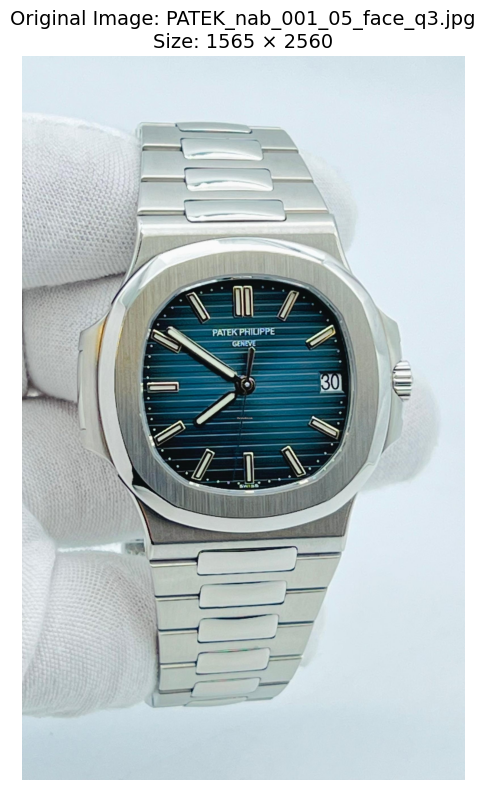

In [6]:
# Display the original image
plt.figure(figsize=(12, 8))
plt.imshow(img_rgb)
plt.title(f"Original Image: {IMAGE_NAME}\nSize: {img_w} × {img_h}", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

## 3. Load Ground Truth Annotation (if available)

In [7]:
from utils.filename_parser import get_image_id

# Get quality-agnostic image ID
image_id = get_image_id(IMAGE_NAME)
print(f"Image ID (quality-agnostic): {image_id}")

# Try to load existing annotation
annotation_file = ANNOTATIONS_DIR / f"{WATCH_ID}.json"
ground_truth = None

if annotation_file.exists():
    with open(annotation_file) as f:
        annotations = json.load(f)
    
    if image_id in annotations:
        ground_truth = annotations[image_id]
        print(f"✓ Found ground truth annotation for {image_id}")
        print(f"  Annotator: {ground_truth.get('annotator', 'unknown')}")
        print(f"  Timestamp: {ground_truth.get('timestamp', 'unknown')}")
        
        # Display keypoints
        coords = ground_truth.get('coords_norm', {})
        print("\n  Ground truth keypoints (normalized):")
        for kp_name in ['top', 'bottom', 'left', 'right', 'center']:
            if kp_name in coords:
                x, y = coords[kp_name]
                print(f"    {kp_name:>6s}: ({x:.3f}, {y:.3f})")
    else:
        print(f"✗ No ground truth annotation found for {image_id}")
else:
    print(f"✗ Annotation file not found: {annotation_file.name}")

Image ID (quality-agnostic): PATEK_nab_001_05
✓ Found ground truth annotation for PATEK_nab_001_05
  Annotator: unknown
  Timestamp: unknown

  Ground truth keypoints (normalized):
       top: (0.493, 0.269)
    bottom: (0.517, 0.642)
      left: (0.206, 0.461)
     right: (0.810, 0.450)
    center: (0.509, 0.456)


## 4. Initialize Pipeline

In [8]:
from prediction_server.core.config import load_config
from prediction_server.pipelines.homography_keypoints import HomographyKeypointsPipeline

# Load configuration
config = load_config(CONFIG_PATH)
print("Pipeline configuration:")
print(f"  YOLO confidence threshold: {config.pipeline.yolo.get('conf_threshold', 0.25)}")
print(f"  LoFTR match threshold: {config.pipeline.loftr.get('match_threshold', 0.2)}")
print(f"  Homography min inliers: {config.pipeline.homography.get('min_inliers', 10)}")
print(f"  Homography RANSAC threshold: {config.pipeline.homography.get('ransac_threshold', 5.0)}")
print(f"  Template model: {config.pipeline.template.get('model', 'nab')}")

# Initialize pipeline (templates are loaded internally by the pipeline)
print(f"\nInitializing pipeline on device: {DEVICE}")

# Convert config to dict and override device settings
pipeline_config = config.pipeline.dict() if hasattr(config.pipeline, 'dict') else config.pipeline
pipeline_config['yolo']['device'] = DEVICE
pipeline_config['loftr']['device'] = DEVICE

pipeline = HomographyKeypointsPipeline(config=pipeline_config)
print("✓ Pipeline initialized successfully")
print(f"✓ Template loaded: {config.pipeline.template.get('model', 'nab')}")

Pipeline configuration:
  YOLO confidence threshold: 0.05
  LoFTR match threshold: 0.2
  Homography min inliers: 10
  Homography RANSAC threshold: 5.0
  Template model: nab

Initializing pipeline on device: mps
Loaded YOLO model from /Users/dhayun/PycharmProjects/WatchMLProjects/watch-image-tagging-tool/prediction_server/models/yolo_watch_face_best.pt on device: mps
Loading LoFTR model (weights=outdoor, device=mps)...


/var/folders/89/88nk46vd17g10zv8hvkkmq6c0000gn/T/ipykernel_5211/3850036620.py:17: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  pipeline_config = config.pipeline.dict() if hasattr(config.pipeline, 'dict') else config.pipeline


LoFTR model loaded successfully
✓ Pipeline initialized successfully
✓ Template loaded: nab


## 5. Run Complete Pipeline

In [9]:
# Run prediction
print(f"Running prediction on: {IMAGE_NAME}")
result = pipeline.predict(str(image_path))

print(f"\nPrediction result:")
print(f"  Success: {result.success}")
print(f"  Confidence: {result.confidence:.3f}")
print(f"  Error: {result.error_message or 'None'}")

if result.debug_info:
    print("\n  Debug info:")
    for key, value in result.debug_info.items():
        if key == "yolo_used_whole_image" and value:
            print(f"    {key}: {value} ⚠️  (YOLO box too small, using whole image)")
        elif key == "yolo_box_height_ratio" and value is not None:
            print(f"    {key}: {value:.1%} of image height")
        else:
            print(f"    {key}: {value}")

if result.keypoints:
    print("\n  Predicted keypoints (normalized):")
    for kp_name in ['top', 'bottom', 'left', 'right', 'center']:
        coords = getattr(result.keypoints, kp_name)
        print(f"    {kp_name:>6s}: ({coords[0]:.3f}, {coords[1]:.3f})")

Running prediction on: PATEK_nab_001_05_face_q3.jpg

Prediction result:
  Success: True
  Confidence: 0.627
  Error: None

  Debug info:
    yolo_detections: 1
    yolo_confidence: 0.9647873640060425
    yolo_used_whole_image: False
    yolo_box_height_ratio: 50.4% of image height
    loftr_matches: 1761
    homography_inliers: 1105
    method: YOLO-LoFTR-Homography
    template_model: nab

  Predicted keypoints (normalized):
       top: (0.489, 0.262)
    bottom: (0.514, 0.641)
      left: (0.188, 0.460)
     right: (0.803, 0.450)
    center: (0.502, 0.453)


In [10]:
# Manually run YOLO detection to get phase1 image dimensions
print("=" * 80)
print("IMAGE DIMENSIONS THROUGH PIPELINE")
print("=" * 80)

# Original query image
print(f"\n1. Original Query Image:")
print(f"   Size: {img_w} × {img_h}")

# Run YOLO detector to get phase1 image
phase1_img, num_det, yolo_conf, reason, obb_data = pipeline.yolo_detector.detect_and_align(
    img_bgr, 
    padding_factor=pipeline.padding_factor,
    template_size=(pipeline.template_data.image_size[1], pipeline.template_data.image_size[0])
)

if phase1_img is not None:
    phase1_h, phase1_w = phase1_img.shape[:2]
    print(f"\n2. Phase 1 Image (after YOLO crop/rotate/resize):")
    print(f"   Size: {phase1_w} × {phase1_h}")
    print(f"   Padding factor: {pipeline.padding_factor}x")
    
    if obb_data:
        print(f"\n   YOLO Detection:")
        print(f"   - Confidence: {yolo_conf:.3f}")
        print(f"   - OBB center: ({obb_data['center_x']:.1f}, {obb_data['center_y']:.1f})")
        print(f"   - OBB size: {obb_data['width']:.1f} × {obb_data['height']:.1f}")
        print(f"   - OBB rotation: {obb_data['rotation_deg']:.1f}°")
        print(f"   - Box height ratio: {obb_data.get('box_height_ratio', 0):.1%} of original image")
        print(f"   - Used whole image: {obb_data.get('used_whole_image', False)}")
        
    # Show coordinate transformation
    print(f"\n" + "=" * 80)
    print("COORDINATE TRANSFORMATION:")
    print("=" * 80)
    print(f"Query image coords → LoFTR matches on Phase1 image → Homography → Template coords")
    print(f"Template keypoints → Inverse Homography → Phase1 coords → Transform → Original coords")
    print(f"\n✅ FIXED: Phase1 coords ({phase1_w}×{phase1_h}) transformed back to original ({img_w}×{img_h})")
    print("=" * 80)
else:
    print(f"\n2. Phase 1 Image: FAILED ({reason})")
    print(f"   ⚠️  YOLO detected no watches - this should fall back to whole image!")

# Template image
template_w, template_h = pipeline.template_data.image_size
print(f"\n3. Template Image:")
print(f"   Size: {template_w} × {template_h}")

IMAGE DIMENSIONS THROUGH PIPELINE

1. Original Query Image:
   Size: 1565 × 2560

2. Phase 1 Image (after YOLO crop/rotate/resize):
   Size: 1158 × 1158
   Padding factor: 1.5x

   YOLO Detection:
   - Confidence: 0.965
   - OBB center: (789.2, 1171.0)
   - OBB size: 1280.4 × 1290.5
   - OBB rotation: 0.0°
   - Box height ratio: 50.4% of original image
   - Used whole image: False

COORDINATE TRANSFORMATION:
Query image coords → LoFTR matches on Phase1 image → Homography → Template coords
Template keypoints → Inverse Homography → Phase1 coords → Transform → Original coords

✅ FIXED: Phase1 coords (1158×1158) transformed back to original (1565×2560)

3. Template Image:
   Size: 772 × 772


### Debug: Image Dimensions Through Pipeline

## 6. Visualize YOLO Detection

YOLO detected 1 watch face(s)

  Detection 1:
    Confidence: 0.965


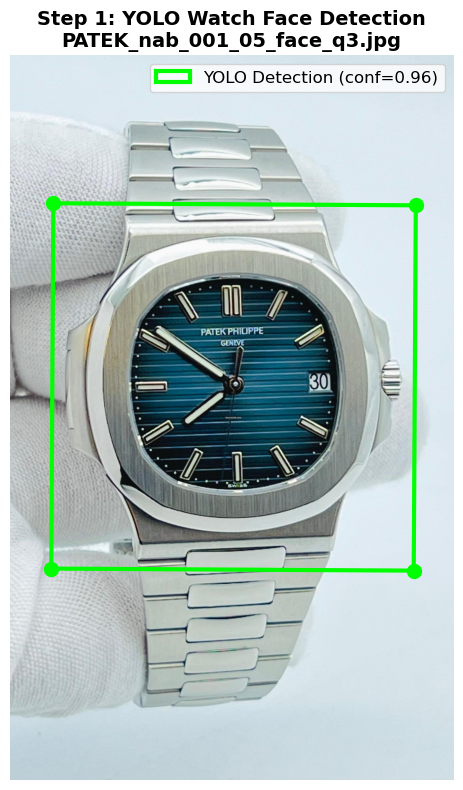

In [11]:
from ultralytics import YOLO

# Load YOLO model
yolo_model_path = project_root / "prediction_server" / "models" / "yolo_watch_face_best.pt"
yolo = YOLO(str(yolo_model_path))

# Run detection
yolo_results = yolo.predict(
    source=str(image_path),
    conf=config.pipeline.yolo.get('conf_threshold', 0.25),
    device=DEVICE,
    verbose=False
)

# Visualize YOLO detections
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(img_rgb)

if len(yolo_results) > 0 and yolo_results[0].obb is not None:
    obbs = yolo_results[0].obb
    print(f"YOLO detected {len(obbs)} watch face(s)")
    
    for i, obb in enumerate(obbs):
        # Get oriented bounding box corners
        corners = obb.xyxyxyxy[0].cpu().numpy()  # Shape: (4, 2)
        confidence = obb.conf[0].item()
        
        print(f"\n  Detection {i+1}:")
        print(f"    Confidence: {confidence:.3f}")
        
        # Draw oriented bounding box
        polygon = patches.Polygon(
            corners,
            linewidth=3,
            edgecolor='lime',
            facecolor='none',
            label=f'YOLO Detection (conf={confidence:.2f})'
        )
        ax.add_patch(polygon)
        
        # Draw corner points
        ax.scatter(corners[:, 0], corners[:, 1], c='lime', s=100, marker='o', zorder=10)
else:
    print("✗ YOLO failed to detect watch face")
    ax.text(img_w/2, img_h/2, 'NO DETECTION', 
           color='red', fontsize=24, ha='center', va='center',
           weight='bold', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax.set_title(f"Step 1: YOLO Watch Face Detection\n{IMAGE_NAME}", fontsize=14, weight='bold')
if len(yolo_results) > 0 and yolo_results[0].obb is not None:
    ax.legend(loc='upper right', fontsize=12)
ax.axis('off')
plt.tight_layout()
plt.show()

## 7. Show Template Image

Template model: nab
Template image size: (772, 772)

Template keypoints (normalized → pixel coordinates):
     top: (0.4952, 0.0024) → (382.3, 1.9) px
    left: (0.0012, 0.5048) → (0.9, 389.7) px
   right: (0.9952, 0.5072) → (768.3, 391.6) px
  bottom: (0.4976, 0.9964) → (384.1, 769.2) px
  center: (0.4964, 0.5012) → (383.2, 386.9) px


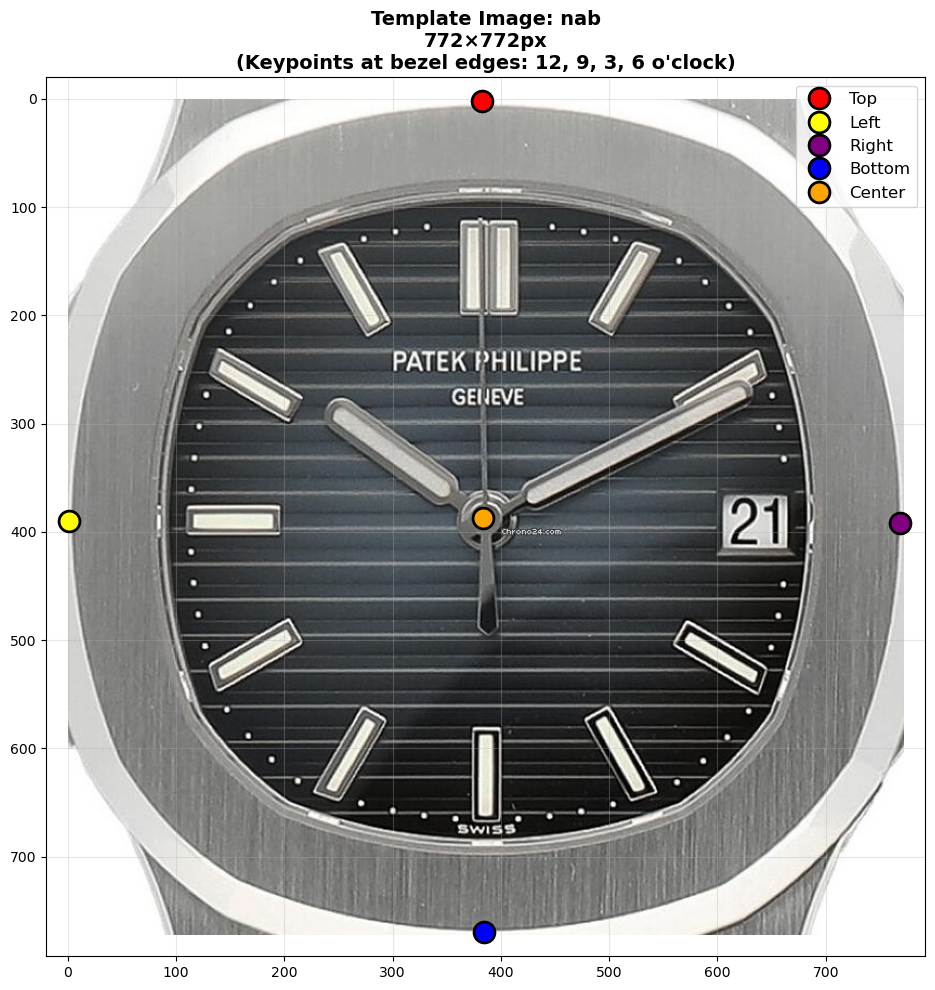


NOTE: Template is tightly cropped to watch face.
Keypoints near 0.0 and 1.0 are CORRECT - they're at the bezel edges.


In [12]:
# Get template data from pipeline (templates are loaded internally)
template_data = pipeline.template_data
template_name = template_data.model_name

print(f"Template model: {template_name}")
print(f"Template image size: {template_data.image_size}")
print(f"\nTemplate keypoints (normalized → pixel coordinates):")

# Convert normalized keypoints to pixel coordinates
template_width, template_height = template_data.image_size
template_keypoints_px = {}
for kp_name, (x_norm, y_norm) in template_data.keypoints_norm.items():
    x_px = x_norm * template_width
    y_px = y_norm * template_height
    template_keypoints_px[kp_name] = (x_px, y_px)
    print(f"  {kp_name:>6s}: ({x_norm:.4f}, {y_norm:.4f}) → ({x_px:.1f}, {y_px:.1f}) px")

# Display template image with keypoints
template_rgb = cv2.cvtColor(template_data.template_image, cv2.COLOR_BGR2RGB)
tmpl_h, tmpl_w = template_rgb.shape[:2]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(template_rgb, extent=[0, tmpl_w, tmpl_h, 0])  # Set explicit extent

# Color mapping for keypoints
keypoint_colors = {
    'top': 'red',
    'bottom': 'blue',
    'left': 'yellow',
    'right': 'purple',
    'center': 'orange'
}

for kp_name, (x, y) in template_keypoints_px.items():
    color = keypoint_colors.get(kp_name, 'white')
    ax.plot(x, y, 'o', color=color, markersize=15, 
            markeredgewidth=2, markeredgecolor='black', label=kp_name.capitalize())

# Set axis limits to ensure full image is shown including edge keypoints
ax.set_xlim(-20, tmpl_w + 20)  # Add padding to show edge points
ax.set_ylim(tmpl_h + 20, -20)  # Inverted Y-axis for image coordinates
ax.set_title(f"Template Image: {template_name}\n{template_width}×{template_height}px\n(Keypoints at bezel edges: 12, 9, 3, 6 o'clock)", 
             fontsize=14, weight='bold')
ax.legend(loc='upper right', fontsize=12)
ax.axis('on')  # Show axes to see coordinates
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nNOTE: Template is tightly cropped to watch face.")
print(f"Keypoints near 0.0 and 1.0 are CORRECT - they're at the bezel edges.")

## 8. Visualize Predicted Keypoints

Predicted keypoints (pixel coordinates):
     top: (765.3, 670.6) px
  bottom: (804.7, 1640.0) px
    left: (294.0, 1177.4) px
   right: (1256.2, 1152.8) px
  center: (785.2, 1160.1) px


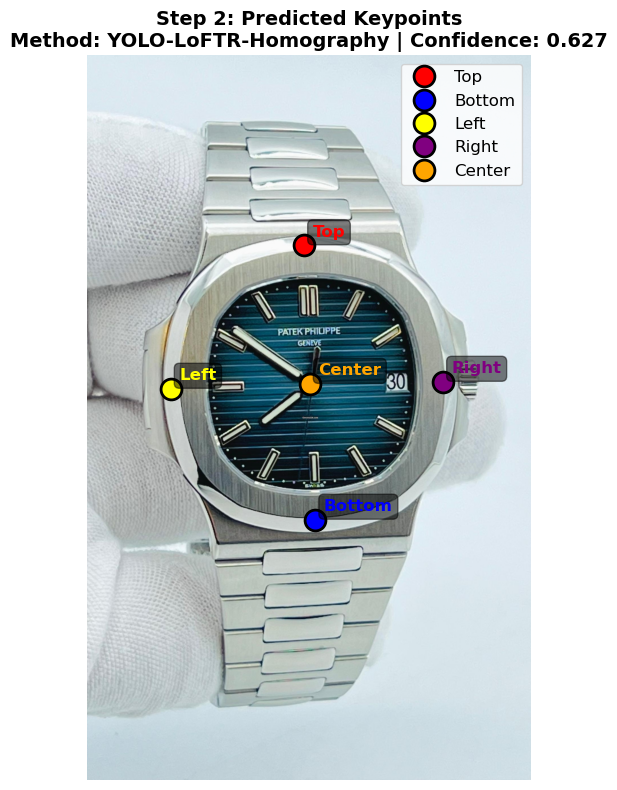

In [13]:
# Visualize predicted keypoints on query image
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(img_rgb)

if result.keypoints:
    keypoint_colors = {
        'top': 'red',
        'bottom': 'blue',
        'left': 'yellow',
        'right': 'purple',
        'center': 'orange'
    }
    
    print("Predicted keypoints (pixel coordinates):")
    for kp_name, color in keypoint_colors.items():
        coords_norm = getattr(result.keypoints, kp_name)
        x_px = coords_norm[0] * img_w
        y_px = coords_norm[1] * img_h
        
        print(f"  {kp_name:>6s}: ({x_px:.1f}, {y_px:.1f}) px")
        
        # Draw keypoint
        ax.plot(x_px, y_px, 'o', color=color, markersize=15, 
               markeredgewidth=2, markeredgecolor='black', label=kp_name.capitalize())
        
        # Add label
        ax.text(x_px + 30, y_px - 30, kp_name.capitalize(), 
               color=color, fontsize=12, weight='bold',
               bbox=dict(boxstyle='round', facecolor='black', alpha=0.5))
    
    method = result.debug_info.get('method', 'Unknown') if result.debug_info else 'Unknown'
    title = f"Step 2: Predicted Keypoints\nMethod: {method} | Confidence: {result.confidence:.3f}"
else:
    title = f"Prediction Failed\nError: {result.error_message}"

ax.set_title(title, fontsize=14, weight='bold')
if result.keypoints:
    ax.legend(loc='upper right', fontsize=12)
ax.axis('off')
plt.tight_layout()
plt.show()

## 9. Compare with Ground Truth (if available)

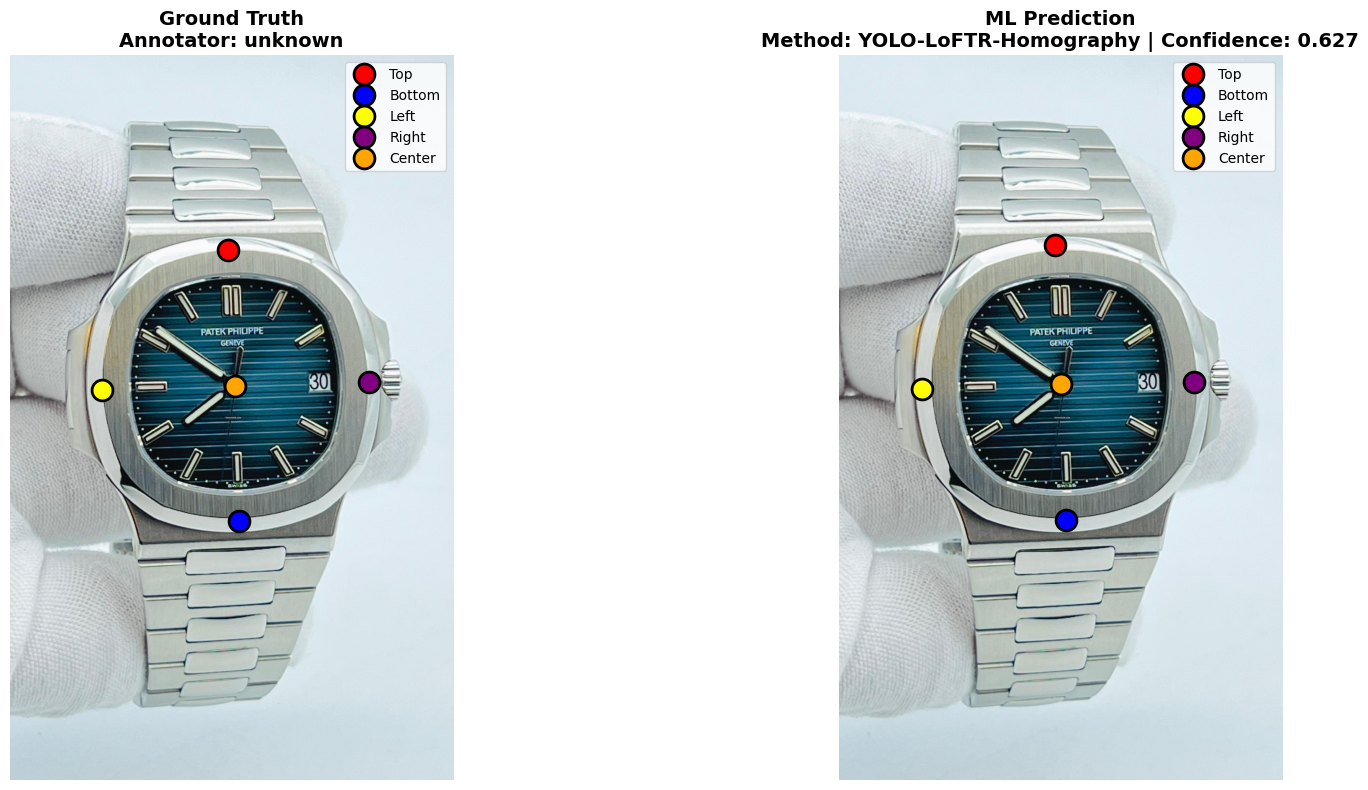


Keypoint Error Analysis:
Keypoint   GT (px)              Pred (px)            Error (px)   Error (%) 
--------------------------------------------------------------------------------
top        ( 771.0,  688.0)  ( 765.3,  670.6)     18.30        0.61%
bottom     ( 809.0, 1644.0)  ( 804.7, 1640.0)      5.89        0.20%
left       ( 323.0, 1180.0)  ( 294.0, 1177.4)     29.10        0.97%
right      (1267.0, 1152.0)  (1256.2, 1152.8)     10.83        0.36%
center     ( 796.0, 1168.0)  ( 785.2, 1160.1)     13.38        0.45%
--------------------------------------------------------------------------------
Mean error: 15.50 px (0.99% of width)
Max error:  29.10 px (left)
Min error:  5.89 px (bottom)


In [14]:
if ground_truth and result.keypoints:
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    keypoint_colors = {
        'top': 'red',
        'bottom': 'blue',
        'left': 'yellow',
        'right': 'purple',
        'center': 'orange'
    }
    
    # Ground truth
    axes[0].imshow(img_rgb)
    gt_coords = ground_truth['coords_norm']
    for kp_name, color in keypoint_colors.items():
        if kp_name in gt_coords:
            x_norm, y_norm = gt_coords[kp_name]
            x_px = x_norm * img_w
            y_px = y_norm * img_h
            axes[0].plot(x_px, y_px, 'o', color=color, markersize=15,
                        markeredgewidth=2, markeredgecolor='black', label=kp_name.capitalize())
    
    axes[0].set_title(f"Ground Truth\nAnnotator: {ground_truth.get('annotator', 'unknown')}",
                     fontsize=14, weight='bold')
    axes[0].legend(loc='upper right')
    axes[0].axis('off')
    
    # Prediction
    axes[1].imshow(img_rgb)
    for kp_name, color in keypoint_colors.items():
        coords_norm = getattr(result.keypoints, kp_name)
        x_px = coords_norm[0] * img_w
        y_px = coords_norm[1] * img_h
        axes[1].plot(x_px, y_px, 'o', color=color, markersize=15,
                    markeredgewidth=2, markeredgecolor='black', label=kp_name.capitalize())
    
    method = result.debug_info.get('method', 'Unknown') if result.debug_info else 'Unknown'
    axes[1].set_title(f"ML Prediction\nMethod: {method} | Confidence: {result.confidence:.3f}",
                     fontsize=14, weight='bold')
    axes[1].legend(loc='upper right')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate pixel errors
    print("\nKeypoint Error Analysis:")
    print(f"{'Keypoint':<10} {'GT (px)':<20} {'Pred (px)':<20} {'Error (px)':<12} {'Error (%)':<10}")
    print("-" * 80)
    
    errors = []
    for kp_name in ['top', 'bottom', 'left', 'right', 'center']:
        if kp_name in gt_coords:
            gt_x, gt_y = gt_coords[kp_name]
            pred_coords = getattr(result.keypoints, kp_name)
            pred_x, pred_y = pred_coords
            
            # Convert to pixels
            gt_x_px, gt_y_px = gt_x * img_w, gt_y * img_h
            pred_x_px, pred_y_px = pred_x * img_w, pred_y * img_h
            
            # Calculate Euclidean distance
            error_px = np.sqrt((gt_x_px - pred_x_px)**2 + (gt_y_px - pred_y_px)**2)
            error_pct = (error_px / np.sqrt(img_w**2 + img_h**2)) * 100
            errors.append(error_px)
            
            print(f"{kp_name:<10} ({gt_x_px:6.1f}, {gt_y_px:6.1f})  ({pred_x_px:6.1f}, {pred_y_px:6.1f})  "
                  f"{error_px:8.2f}      {error_pct:6.2f}%")
    
    print("-" * 80)
    print(f"Mean error: {np.mean(errors):.2f} px ({np.mean(errors)/img_w*100:.2f}% of width)")
    print(f"Max error:  {np.max(errors):.2f} px ({['top', 'bottom', 'left', 'right', 'center'][np.argmax(errors)]})")
    print(f"Min error:  {np.min(errors):.2f} px ({['top', 'bottom', 'left', 'right', 'center'][np.argmin(errors)]})")
    
elif ground_truth and not result.keypoints:
    print("Ground truth available but prediction failed")
elif not ground_truth and result.keypoints:
    print("Prediction succeeded but no ground truth available for comparison")
else:
    print("No ground truth and prediction failed")

## 10. Pipeline Summary

In [15]:
print("=" * 80)
print("PIPELINE SUMMARY")
print("=" * 80)
print(f"\nImage: {IMAGE_NAME}")
print(f"Image ID: {image_id}")
print(f"Size: {img_w} × {img_h}")
print(f"\nPipeline Result:")
print(f"  Success: {result.success}")
print(f"  Confidence: {result.confidence:.3f}")

if result.debug_info:
    print(f"\nPipeline Steps:")
    print(f"  Method: {result.debug_info.get('method', 'Unknown')}")
    print(f"  Template: {result.debug_info.get('template_model', 'Unknown')}")
    
    if 'yolo_detections' in result.debug_info:
        print(f"  YOLO detections: {result.debug_info['yolo_detections']}")
    if 'yolo_confidence' in result.debug_info:
        print(f"  YOLO confidence: {result.debug_info['yolo_confidence']:.3f}")
    if 'loftr_matches' in result.debug_info:
        print(f"  LoFTR matches: {result.debug_info['loftr_matches']}")
    if 'homography_inliers' in result.debug_info:
        print(f"  Homography inliers: {result.debug_info['homography_inliers']}")

if result.error_message:
    print(f"\nError: {result.error_message}")

if ground_truth and result.keypoints and 'errors' in locals():
    print(f"\nAccuracy vs Ground Truth:")
    print(f"  Mean error: {np.mean(errors):.2f} px ({np.mean(errors)/img_w*100:.2f}% of width)")
    print(f"  Max error: {np.max(errors):.2f} px")

print("=" * 80)

PIPELINE SUMMARY

Image: PATEK_nab_001_05_face_q3.jpg
Image ID: PATEK_nab_001_05
Size: 1565 × 2560

Pipeline Result:
  Success: True
  Confidence: 0.627

Pipeline Steps:
  Method: YOLO-LoFTR-Homography
  Template: nab
  YOLO detections: 1
  YOLO confidence: 0.965
  LoFTR matches: 1761
  Homography inliers: 1105

Accuracy vs Ground Truth:
  Mean error: 15.50 px (0.99% of width)
  Max error: 29.10 px
